# Project

Lin Zhu lin_zhu@g.harvard.edu

Alice Li anqili@g.harvard.edu

### Project description

This project aimed at implement the algorithm of Style Transfer via Texture Synthesis https://arxiv.org/abs/1609.03057.

The study achieved the image artistic style transfer based on classic pixel-based loss optimization. It ultilizes EM in loss optimization since the loss itself contains minimization. Meanwhile, the study employes the spirit of stochatic gradients at the pixel patch sweep steps. Instead of including all patches in content and style images in the loss function, the optimization updates only take part of patches to avoid local minima.

This study is very fast and convenient compared to deep learning methods. It requries no pre-trained model and short optimization time with several dimensionality reduction techniques.

Our goal is to implement the proposed algorithm and experiment around the functions of parameters in the optimization steps.

# Study main ideas

### Overall steps 

In this study the input images are one content image and one style image. The stylized image should contain both the semantics of content image and the artistic style of the style image 

1. content image segmentation
2. color transfer from content to style image
3. style transfer


### Style transfer algorithm Summary

1. An **initialization** of the algorithm by the content image, augmented by very strong noise, in order to both tie the result to the content in selected areas, while enabling it to depart from it elsewhere.


2. Apply EM steps on optimization of overall loss:

$$\text{total loss} = \frac{1}{c}\sum \min_{k,l} ||R_{i,j}^n\underline{X} - Q_{k,l}^n\underline{S}||_2^r + ||\underline{X} - \underline{C}||_W^2 + \lambda \rho(X)$$

where: $Q_{k,l}^n =\text{the style image pixel patch at location (k,l) when patch size = n}$

$R_{i,j}^n =\text{the target image pixel patch at location (i,j) when patch size = n}$

$c$ is a regulizer to adjust the porportion of content and style loss

**E step**: solve out $R_{i,j}^n$ by searching for nearest neighbor in content image. The distance is measured by Euclidean distance of patch vectors.

**M step** solve the minimization problem $$\min \frac{1}{c}\sum ||R_{i,j}^n\underline{X} - \underline{z_{i,j}}||_2^r + ||\underline{X} - \underline{C}||_W^2 + \lambda \rho(X)$$

This problem is solved by study in robust optimization and can also be divided into EM steps. The core is to use IRLS in E step and use the closed form solution of Augmented Lagrangian in M step.

**E(1) step:** $\min_{\underline{X}}\sum ||R_{i,j}^n\underline{X} - \underline{z_{i,j}}||_2^r$,

this problem can be converted to $\underline{\hat X} = \min_{\underline{X}}\sum w_{i,j}||R_{i,j}^n\underline{X} - \underline{z_{i,j}}||_2^2$

where $w_{i,j} =\sum ||R_{i,j}^n\underline{X} - \underline{z_{i,j}}||_2^{r-2} $

**M(1):** $X = (W+I)^{-1}(\underline{\hat X}+W\underline{C})$ This is the approximate solution derived from Augmented Lagrangian.


###NOTE: 

All processes above are applied to varying patch-sizes and several resolution scales of the images (content, style, segmentation).  We deploy a sweep over the patch sizes and the
scales sequentially. This has the spirit of the stochastic gradient descent approach, where each patch-size and
resolution level contributes its in
influence to the final outcome separately, thus leading to a better steady-state
 nal result, with better chances of avoiding local minima.






# Documentation



**color_transfer(content, style)** 
transfer the color from content to the style by histogram matching. This function is critical to 

Parameters: 
- content: the content image matrix with 3 color channels
- style: the style image matrix with same dimensions as content

Returns: 
-  the color-transferred content image matrix 



**GuassianPyramid(**kwargs)**

Down scale images for operating over a Gaussian pyramid.

Parameters:
- **kwargs: image matrices

Returns: 
- a list of Gaussian pyramid matrices


**projection(IMG, proj)**

Project the images onto a projection matrix space. This function is used when patch-size <= THRESHOLD so that the number of patches is large. The objective is to accelerate the algorithm and smooth the stylized images.

Parameters:
- IMG: the image matrix
- proj: projection matrix

Returns:
- the IMG projected matrix on proj space

**ContentFusion(Segment,content,X,padding)**

Implemented the M step in IRLS robust optimization: $X = (W+I)^{-1}(\underline{\hat X}+W\underline{C})$

Parameters:
- Segment: one channel 3D segementation mask W
- content: 3D 3 channel content image matrix $\underline{C}$
- X: 3D 3 channel content image matrix $\underline{X}$
- padding: the length of padding size used for image edge extension.

Returns: the updated target image matrix $\underline{X}$


**KNN(p_size,style_patches)**

Find the nearest neighbor of each patch in style image (style_patches). The distance is measured by Euclidean distance of the image vectors.

That is, to solve the minimization problem:
$\min_{k,l} ||R_{i,j}^n\underline{X} - Q_{k,l}^n\underline{S}||_2^r$

Parameters:
- p_size: the size of style image patches
- style_patches: a 6D array where the first 2 dimensions describe the location of the patch in style image and the last 3 dimension describe the pixel values.

Returns:
- neighbors:the KNN object which is fit to each style image patch.
- style_patches_arr: a 2D arary where the first dimension describes the indices of each patch in style image and the second dimension describes the pixel values of the style image matrix in vector form.


**update_X(X, X_patches,style_patches_arr,neighbors, p_index,proj = None)**

Update the target image matrix X after downscaling, initialization, color transfer and finding the neighbors of style image patches. It solves the minimization problem $\underline{X} = \min_{\underline{X}}\sum ||R_{i,j}^n\underline{X} - \underline{z_{i,j}}||_2^r$ by IRLS.

Parameters
- X: the 3D array of target image matrix
- X_patches: the 6D array of target image patches
- style_patches_arr: the 2D array of style image patches
- neighbors: the KNN object which is fit to each style image patch.
- p_index: the index used to loop over the patches sizes and patch sampling gaps.
- proj: project the X_patches onto the proj matrix space so that the dimension of X_patches would be the same as style_patches.

Returns:
- None

**style_transfer(content, style, segmentation_mask)**

Go through the process of content image segmentation, color transfer, downscaling and style transfer updates.

Parameters:
- content: 3D content image matrix. The color transfer should already be applied to content image.
- style: 3D style image matrix.
- segmentation_mask: the one channel 3D segmentation matrix used for highlighting style transfer parts in content image.

Returns:
- X: the 3D target image matrix.







# Implementation

Our implementation followed the detailed documentation of steps presented in the paper and the work of https://github.com/rka97/style_transfer. We referred to the github work's API structure and computer vision packages and wrote our own optimization steps and implmentation for each function.


In [0]:
import skimage.io as io
import cv2 as cv2
import matplotlib.pyplot as plt
from skimage import img_as_float
from skimage.color import rgb2gray
from numpy.linalg import eig
from numpy.linalg import multi_dot
import numpy as np
from sklearn.decomposition import PCA
from sklearn.feature_extraction.image import extract_patches
from skimage.segmentation import chan_vese, morphological_chan_vese
from skimage.filters import gaussian
import math
from scipy.ndimage import binary_fill_holes
from skimage.morphology import watershed, disk, dilation
from sklearn.feature_extraction.image import extract_patches
from skimage.util import img_as_ubyte
from skimage.filters import rank
from scipy.spatial import Delaunay
from scipy import ndimage as ndi
from skimage.draw import polygon
from skimage.exposure import cumulative_distribution
from timeit import default_timer as timer
from skimage.util import view_as_windows, pad, random_noise
from sklearn.neighbors import NearestNeighbors
from skimage.segmentation import *
import collections

In [64]:

# # used for colab with path drive/My Drive/AM207/Final_Proj
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Set Parameters (Page 17 Part 4)

First of all we import the content image and style image.We first set initial parameters. The parameters in the following code blocks are all  directly drawn from the paper to ensure a faithful reproduction of the final results.

###Parameter Initialization


*   LMAX - Number of resolution layers 
*   IM_SIZE - Image size 
*   PATCH_SIZE - patch sizes 
*   IALG - number of update iterations per patch size
*   IRLS_r - robust statistics value ( chosen 0.8 in paper)
*   IRLS_it - number of IRLS iterations (chosen as 10 in paper)
*   INFO - threshold for PCA (0.8 in code, 0.95 in paper)
*   P_SIZE_THRESHOLD - patch size below which PCA is used
*   PARAM_1, PARAM_2 - Segmentation parameters (empirical)


In [0]:
LMAX = 3
IM_SIZE = 300
PATCH_SIZES = np.array([33, 21, 13, 9, 5])
SAMPLING_GAPS = np.array([28, 18, 8, 5, 3])
IALG = 10
IRLS_it = 3
INFO = 0.9 
IRLS_r = 0.8
P_SIZE_THRESHOLD = 20
#Set the path to images
# PATH_content = './drive/My Drive/AM207/Final_Project/content_images/'
# PATH_style = './drive/My Drive/AM207/Final_Project/style_images/'
# PATH_save = './drive/My Drive/AM207/Final_Project/stylized_images/'

PATH_content = './content_images/'
PATH_style = './style_images/'
PATH_save = './stylized_images/'

In [0]:
#content_img = 'Tuebingen_Neckarfront.jpg'
content_img = 'Tuebingen_Neckarfront.jpg'
style_img = 'van_gogh.jpg'

In [0]:
content = io.imread(PATH_content +content_img) / 255.0
content = content[:,:,:3] #make sure there are only 3 color channels 
style = io.imread(PATH_style + style_img) / 255.0
content = (cv2.resize(content, (IM_SIZE, IM_SIZE))).astype(np.float32)
style = (cv2.resize(style, (IM_SIZE, IM_SIZE))).astype(np.float32)

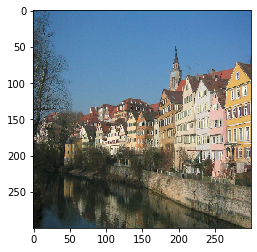

In [68]:
plt.imshow(content)

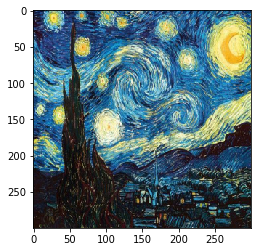

In [69]:
plt.imshow(style)

## Edge Segmentation (P13 Part 3.4)

Detect the objects. The segmentation matrix is used to highlight the part we want to implement style transfer. Therefore the content loss is:

$$ \text{content loss} = ||\underline{X} - \underline{C}||_W^2$$

Here we set parameters for segmentation and perform image segmentation (shown in the segmentation edges graph as below). The parameter are chosen empirically after different trials of experiments

In [0]:
PARAM_1 = 100
PARAM_2 = 120

In [0]:
#Segmentation
imgs= cv2.imread(PATH_content +content_img,0)
edges = cv2.Canny(imgs,PARAM_1,PARAM_2)
segm_mask = (cv2.resize(edges, (IM_SIZE, IM_SIZE))).astype(np.float32)

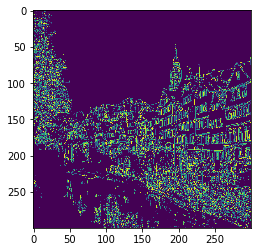

In [72]:
plt.imshow(segm_mask)

## Color transfer 

Applying color-transfer from the style to the content within the iterative process, in order to preserve the richness of the style in the final outcome and avoid repetitive patterns, and perhaps the most important
of all.

**Note: The implementation of this particular method is directly used from the reference source code mentioned above (since it is not directly related to core update inside the iterations (only happens at the beginning and the end) ).**

In [0]:
def color_transfer(content, style):
    transfered = np.copy(content)
    # for each channel of the content, match the cum_histogram with the style's one
    for i in range(0, content.shape[2]):
        content_channel = content[:, :, i].flatten()
        style_channel = style[:, :, i].flatten()
        # calculate histogram for both content and style
        content_values, content_indices, content_counts = np.unique(content_channel, return_inverse=True, return_counts=True)
        style_values, style_counts = np.unique(style_channel, return_counts=True)
        # calculate cummulative histogram
        content_cumhist = np.cumsum(content_counts)
        style_cumhist = np.cumsum(style_counts)
        # normalize it
        content_cumhist = content_cumhist / np.max(content_cumhist)
        style_cumhist = style_cumhist / np.max(style_cumhist)
        # match using interpolation
        matched = np.interp(content_cumhist, style_cumhist, style_values)
        transfered[:, :, i] = matched[content_indices].reshape(content[:, :, i].shape)
    return transfered

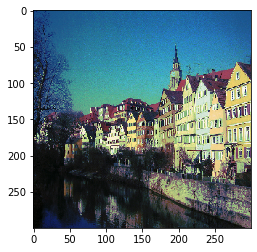

In [74]:
A = color_transfer(content, style)
plt.imshow(A)

## Style Transfer

### Initialization : Guassian Pyramid (Page 31 ,Fig 18)




In [0]:
def GuassianPyramid(**kwargs):
    IMGS={}
    for key, value in kwargs.items():
        try:
           rows, cols, _channels = map(int, value.shape)
        except:
           rows, cols = map(int, value.shape)
        IMGS[key] =  cv2.pyrDown(value, dstsize=(cols // 2, rows // 2))
    return list(IMGS.values())



### Dimension Reduction: PCA (Page 16)
PCA is used to reduce the dimension of patches  when the patch sizes are small in order to  guarantee the efficiency of the algorithm. In particular, the computation of projection matrix and eigen values and vectors are computed used sklearn.PCA library.

In [0]:
#This method project the image into the reduced style space
def projection(IMG, proj):
    IMG = IMG - np.mean(IMG.T, axis=1)
    return (np.matmul(proj, IMG.T)).T

###Content Fusion (Page 12 Equation 15)

 $X = (W+I)^{-1}(\underline{\hat X}+W\underline{C})$

W: Segmentation

I :identities

X: intermediate X

C content Image

In [0]:

def ContentFusion(Segment,content,X,padding):
  '''
  Segment :W   2D ARRAY
  Xhat :X 3D ARRAY
  C:Content 3D ARRAY
  '''

  #convert segmentation into 3 dimension for multiplication with content img
  dx,dy = Segment.shape
  convert_seg = Segment.reshape(dx,dy,1)
  # identity = np.identity(dx).reshape(dx,dy,1)
  left = (convert_seg+1)**-1
  right = convert_seg*content
  #Padding
  left =cv2.copyMakeBorder(left, top =  0, bottom = padding, left = 0 , right = padding , borderType = cv2.BORDER_WRAP).reshape(padding+dx,padding+dx,1)
  right = cv2.copyMakeBorder(right, top =  0, bottom = padding, left = 0 , right = padding , borderType = cv2.BORDER_WRAP)
  return left*(X+right)


###KNN Page 16 Part 3.6

In [0]:
def KNN(p_size,style_patches):
    """
    this function is used to find nearest neighbor in content image corresponding 
    to the patch in style images
    """
    #Reduce Dimension into P_L,n of size n x M_Ln (number of possible patches)
    if p_size > P_SIZE_THRESHOLD:
      #If the patch size is smaller than the P_SIZE_ThRESHOLD,we prepare to reduce dimension otherwise dont
      style_patches_arr = style_patches.reshape(-1,p_size*p_size*3) #Reduce Dimension into P_L,n of size n x M_Ln (number of possible patches)
    else:
      style_patches_arr = style_patches
   
    neighbors = NearestNeighbors(n_neighbors=1).fit(style_patches_arr)
    return style_patches_arr,neighbors

###IRLS Page 12 (Equation 13 ,14,15)

In [0]:
def update_X(X, X_patches,style_patches_arr,neighbors, p_index,proj = None):
    """"
    Solve minimization problem \sum wi||RX-z||^2 by IRLS
    """
    p_size = PATCH_SIZES[p_index]
    X_patches_arr = X_patches.reshape(-1, p_size*p_size*3)

    if p_size <= P_SIZE_THRESHOLD:
      X_patches_arr = projection(X_patches_arr,proj)

    distances, indices = neighbors.kneighbors(X_patches_arr)
    distances += 0.0001 #avoid NA error
    weights = np.power(distances,IRLS_r-2)
    D = np.zeros(X.shape)
    Dp = extract_patches(D, patch_shape=(p_size, p_size, 3), \
                                        extraction_step=SAMPLING_GAPS[p_index])
    p = 0

    #reweight RX = z to solve the minimization problem (IRLS)
    X_patches[:] = 0
    for i in range(X_patches.shape[0]):
        for j in range(X_patches.shape[1]):
            style_fill = style_patches_arr[indices[p][0],:].reshape(p_size, p_size, 3)
            X_patches[i,j,0,:,:] += weights[p]*style_fill
            Dp[i,j,0,:,:,:] += weights[p]
            p+=1
    try:
      X /= D
    except:
      D+= 0.00001
      X /= D
            

###Implementation Details P18

This implementation closely follows the algorithm described in Page 18

In [0]:

def style_transfer(content, style, segmentation_mask):


    #Initialization : Color_transfer from style to content
    content =  color_transfer(content, style)

        
    #Build Guassian Pyramids for our Layers
    CONTENT_ARR=[content]
    STYLE_ARR=[style]
    SEG_ARR =[segmentation_mask]

    for i in range (LMAX-1):
        content,Style,segmentation_mask = GuassianPyramid(content = CONTENT_ARR[-1],style = STYLE_ARR[-1], segment = SEG_ARR[-1])
        CONTENT_ARR.append(content)
        STYLE_ARR.append(Style)
        SEG_ARR.append(segmentation_mask)


    #Initialize Random Noise
    X = random_noise(CONTENT_ARR[-1], mode='gaussian', var=50)

    print('Starting Style Transfer..')
    #Loop Over Scale Lmax
    for L in range(LMAX-1, -1, -1):  # over scale L in reverse order
        print('Scale', L)
        style_sx, style_sy, _ = STYLE_ARR[L].shape

        for n in range(PATCH_SIZES.size):  # over patch size n
            s_gap = SAMPLING_GAPS[n] 
            p_size = PATCH_SIZES[n]
            print('Patch Size', p_size)
            #This calculate the number of patches in a given row
            npatchx = int((style_sx - p_size) / s_gap + 2)	

            # The images are padded so that each line can be divide up into complete patches. 
            padding = p_size  + npatchx * s_gap -style_sx 

            #Here we use wrapping (repeating images) as the padding methods
            current_style = cv2.copyMakeBorder(STYLE_ARR[L], top =  0, bottom = padding, left = 0 , right = padding , borderType = cv2.BORDER_WRAP)   
            X = cv2.copyMakeBorder(X, top =  0, bottom = padding, left = 0 , right = padding , borderType = cv2.BORDER_WRAP)  
            X_patches =  extract_patches(X,  patch_shape=(p_size, p_size, 3), \
                                        extraction_step=s_gap)
    
         
            #style_patches: neighbors(Q) = argmin||RX-QS||
            style_patches = extract_patches(current_style,  patch_shape=(p_size, p_size, 3), \
                                            extraction_step=s_gap)
            #KNN initialization
            #If p_size < a certain threshold, perform pca to ensure compuational Efficiency 
            if p_size<= P_SIZE_THRESHOLD:
              pca = PCA(INFO)
              style_patches_arr = style_patches.reshape(-1,p_size*p_size*3)
              new_style_patches = pca.fit_transform(style_patches_arr)
              project_matrix = pca.components_
              #KNN
              new_style_patches_arr,neighbors = KNN(p_size,new_style_patches)
            else:
              style_patches_arr,neighbors = KNN(p_size,style_patches)

            #Recover to origin shape
            style_patches_arr = style_patches_arr.reshape((-1, p_size, p_size, 3))

            for k in range(IALG):
              for i in range(IRLS_it):
                X_patches = extract_patches(X,  patch_shape=(p_size, p_size, 3), \
                                            extraction_step=s_gap)
 
                if p_size <=P_SIZE_THRESHOLD:
                     #If patch size is too small, need to first project it to the projection matrix of style image first 
                    update_X(X, X_patches,style_patches_arr,neighbors, n,proj = project_matrix)
                else:
                    update_X(X, X_patches,style_patches_arr,neighbors, n)
                    
              # Step 3: Content Fusion
              X = ContentFusion(SEG_ARR[L],CONTENT_ARR[L],X,padding)
              # Step 4: Color Transfer
              X = color_transfer(X, style)

              #We omit the denoise step since it won't influence the result by too much

            X = X[:style_sx, :style_sx, :]  # Discard padding.
        # Upscale X
        if (L > 0):
            x, y, _ = CONTENT_ARR[L - 1].shape
            X = cv2.resize(X, (x, y))
    return X


In [112]:
INFO = 0.9
start = timer()
X = style_transfer(content,style,segm_mask)
end=timer()
print("Total Time used:",-start + end)


Starting Style Transfer..
Scale 2
Patch Size 33
Patch Size 21
Patch Size 13
Patch Size 9
Patch Size 5
Scale 1
Patch Size 33
Patch Size 21
Patch Size 13
Patch Size 9
Patch Size 5
Scale 0
Patch Size 33
Patch Size 21
Patch Size 13
Patch Size 9
Patch Size 5
Total Time used: 75.56550452099873


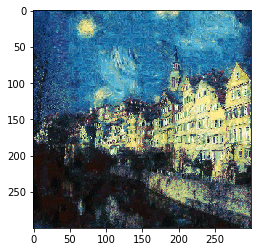

In [113]:
plt.imshow(X)

In [0]:
#parameters
LMAX = 3
IM_SIZE = 400
PATCH_SIZES = np.array([33, 21, 13, 9, 5])
SAMPLING_GAPS = np.array([28, 18, 8, 5, 3])
IALG = 10
IRLS_it = 6 #Need 6 iterations to fulling mingle some style images
INFO = 0.9
IRLS_r = 0.8
P_SIZE_THRESHOLD = 20
PARAM_1 = 100
PARAM_2 = 120
#Set the path to images
# PATH_content = './drive/My Drive/AM207/Final_Project/content_images/'
# PATH_style = './drive/My Drive/AM207/Final_Project/style_images/'
# PATH_save = './drive/My Drive/AM207/Final_Project/stylized_images/'

PATH_content = './content_images/'
PATH_style = './style_images/'
PATH_save = './stylized_images/'



def main(content_img, style_img, save = False):
    #prepare images
    content = io.imread(PATH_content +content_img) / 255.0
    content = content[:,:,:3] #make sure there are only 3 color channels 
    style = io.imread(PATH_style + style_img) / 255.0

    content = (cv2.resize(content, (IM_SIZE, IM_SIZE))).astype(np.float32)
    style = (cv2.resize(style, (IM_SIZE, IM_SIZE))).astype(np.float32)

    #segmentation
    imgs= cv2.imread(PATH_content +content_img,0)
    edges = cv2.Canny(imgs,PARAM_1,PARAM_2)
    segm_mask = (cv2.resize(edges, (IM_SIZE, IM_SIZE))).astype(np.float32)

    #style transfer
    start = timer()
    X = style_transfer(content,style,segm_mask)
    end=timer()
    print("Total Time used:",-start + end)

    plt.imshow(X) 

    if save:
       plt.savefig(PATH_save+ content_img[:-4]+'-'+style_img[:-4]+'.jpg')
    

# Work display

Starting Style Transfer..
Scale 2
Patch Size 33
Patch Size 21
Patch Size 13
Patch Size 9
Patch Size 5
Scale 1
Patch Size 33
Patch Size 21
Patch Size 13
Patch Size 9
Patch Size 5
Scale 0
Patch Size 33
Patch Size 21
Patch Size 13
Patch Size 9
Patch Size 5
Total Time used: 142.04257560900078


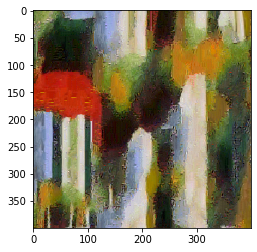

In [104]:
#sanity check: check the randomness of stylized image by using an empty content image as input
LMAX = 3
PATCH_SIZES = np.array([33, 21, 13, 9, 5])
SAMPLING_GAPS = np.array([28, 18, 8, 5, 3])
main('empty.jpg', 'paint.jpg', save = True)

Starting Style Transfer..
Scale 2
Patch Size 33
Patch Size 21
Patch Size 13
Patch Size 9
Patch Size 5
Scale 1
Patch Size 33
Patch Size 21
Patch Size 13
Patch Size 9
Patch Size 5
Scale 0
Patch Size 33
Patch Size 21
Patch Size 13
Patch Size 9
Patch Size 5
Total Time used: 157.56698009499996


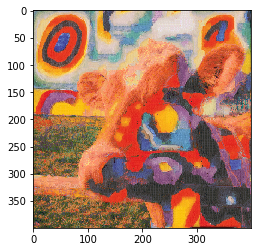

In [106]:
main('cow.jpg','colored squares.jpg', save = True)

Starting Style Transfer..
Scale 2
Patch Size 33
Patch Size 21
Patch Size 13
Patch Size 9
Patch Size 5
Scale 1
Patch Size 33
Patch Size 21
Patch Size 13
Patch Size 9
Patch Size 5
Scale 0
Patch Size 33
Patch Size 21
Patch Size 13
Patch Size 9
Patch Size 5
Total Time used: 127.78038505300174


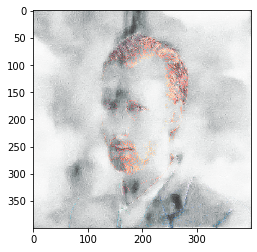

In [110]:
main('face_blue.jpg',  'pencil-sketch.jpg', save =True )

Starting Style Transfer..
Scale 2
Patch Size 33
Patch Size 21
Patch Size 13
Patch Size 9
Patch Size 5
Scale 1
Patch Size 33
Patch Size 21
Patch Size 13
Patch Size 9
Patch Size 5
Scale 0
Patch Size 33
Patch Size 21
Patch Size 13
Patch Size 9
Patch Size 5
Total Time used: 179.53871413900015


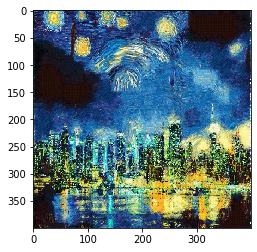

In [111]:
main('NY.jpg',  'van_gogh.jpg', save =True )

# Conclusion

We have successfully implemented the image artistic style transfer based on the proposed algorithm. Each style transfer can be achieved within 160 seconds on CPU. 

Throughout this project, we can provide an alternative style-transfer implementation without a large pre-trained CNN model and hours of style-transfer training on GPU. And the resulted images contain the artistic style of style images while also keeping the semantics of the content image.

The EM optimization on this classic pixel-based loss shows a fast and elegant way to derive approximate minima while keeping the spirit of stochastic optimization by jumping through the extracted image patches. If we use traditional numerical analysis way to calculate the optima such as BFGS, it is possible to get stuck at local minima and the computational cost is as high as 20 seconds/iteration when the target matrix size is 400, which is very usual for image size. Limiting the max iteration number would greatly compromise the accuracy of the results since the results from numerical analysis are derived from the ground while the closed solution of EM updates can reserve the results before new updates.

We noticed that when the patch size is large, the stylized images are not very smooth and natural. The IRLS can achieve a good update when the iteration number is 3. Meanwhile, segmentation is critical to the success. For simplicity, we only used edge segmentation here. In general, face segmentation and 

Due to the nice and fast result, it is hard to improve the current optimization algorithm when employing the proposed loss function. 

However, more attention can be brought into the manipulation of the PCA threshold and the evolution of patch size. For now, our patch sizes are deterministic. But the quality of images, as our numerous experiment shows, rely heavily on the patch sizes. Some images are good at adapting to patches while others don't. It could be possible we stochastically decide the patched size by using some of the image properties and update the array of patch sizes in each scale stochastically.

It would also be nice to further investigate the utilization of randomness in the algorithm such as noise formation to help better blend content and style together if they are inherently very different. The better blend of content and style image can also be done by a dynamic determination of the PCA threshold. As our experiment shows, if the content image and style image are very different and the content image is very detailed (paint.jpg), A high PCA threshold (0.95 as paper propose) will fail to transfer the context info properly if there is a huge blank space in the content image (like the sky). If we tune down PCA by to 0.8, the result is much better. It would be interesting to see if we can integrate any stochastic method in the manipulation of dimension reduction.

Also in general, further study of classic style transfer methods could consider the combination of the graphic probabilistic model and Bayesian latent variable model.


